In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os

# Eurovision Song Contest (ESC) Analysis

## Data Familiarization

In [108]:
# Get current directory
cwd = os.getcwd()
print(cwd)

c:\Users\mate1\OneDrive\Escritorio\Repository\Eurovision_Contest_Analysis


In [109]:
# Load data
df_votes = pd.read_csv('Data/votes.csv')
df_votes.head()

,year,round,from_country_id,to_country_id,from_country,to_country,total_points,tele_points,jury_points
0,1957,final,at,nl,at,nl,6,NaN,NaN
1,1957,final,at,fr,at,fr,0,NaN,NaN
2,1957,final,at,dk,at,dk,0,NaN,NaN
3,1957,final,at,lu,at,lu,3,NaN,NaN
4,1957,final,at,de,at,de,0,NaN,NaN


In [110]:
# Get the initial and last years of the data
initial_year = df_votes['year'].min()
final_year = df_votes['year'].max()
print('Initial year:', initial_year)
print('Final year:', final_year)

Initial year: 1957
Final year: 2023


### Data Cleaning

In this work we are only interested in the final round.

In [111]:
# Get only the final round
df_final_round = df_votes[df_votes['round'] == 'final']

In [112]:
# Remove giving 0 points
df_final_round = df_final_round[df_final_round['total_points'] > 0]

In [113]:
# Get the total number of countries
total_countries = df_final_round['from_country_id']
total_countries = np.array(total_countries)
total_countries = np.unique(total_countries)
print('Total countries:', total_countries)
print('Number of countries:', len(total_countries))

Total countries: ['ad' 'al' 'am' 'at' 'au' 'az' 'ba' 'be' 'bg' 'by' 'ch' 'cs' 'cy' 'cz'
 'de' 'dk' 'ee' 'es' 'fi' 'fr' 'gb' 'ge' 'gr' 'hr' 'hu' 'ie' 'il' 'is'
 'it' 'lt' 'lu' 'lv' 'ma' 'mc' 'md' 'me' 'mk' 'mt' 'nl' 'no' 'pl' 'pt'
 'ro' 'rs' 'ru' 'se' 'si' 'sk' 'sm' 'tr' 'ua' 'wld' 'yu']
Number of countries: 53


In [114]:
# Broadcast the Yugoslavia points to their actual countries
broadcast = {
    'yu': ['ba', 'hr', 'mk', 'rs', 'si'],
    'cs': ['rs', 'me']
}

df_final_round['from_country_id'] = df_final_round['from_country_id'].apply(lambda x: broadcast[x] if x in broadcast.keys() else x)
df_final_round['to_country_id'] = df_final_round['to_country_id'].apply(lambda x: broadcast[x] if x in broadcast.keys() else x)
df_final_round.explode('from_country_id').explode('to_country_id')

,year,round,from_country_id,to_country_id,from_country,to_country,total_points,tele_points,jury_points
0,1957,final,at,nl,at,nl,6,NaN,NaN
3,1957,final,at,lu,at,lu,3,NaN,NaN
6,1957,final,at,gb,at,gb,1,NaN,NaN
10,1957,final,be,nl,be,nl,5,NaN,NaN
11,1957,final,be,fr,be,fr,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...
51340,2023,final,wld,hr,wld,hr,3,3.0,NaN
51341,2023,final,wld,am,wld,am,8,8.0,NaN
51343,2023,final,wld,fr,wld,fr,1,1.0,NaN
51344,2023,final,wld,es,wld,es,2,2.0,NaN


In [115]:
# Dictionary with the real name of the countries
country_id_to_name = {
    'ad': 'Andorra',
    'al': 'Albania',
    'am': 'Armenia',
    'at': 'Austria',
    'au': 'Australia',
    'az': 'Azerbaijan',
    'ba': 'Bosnia and Herzegovina',
    'be': 'Belgium',
    'bg': 'Bulgaria',
    'by': 'Belarus',
    'ch': 'Switzerland',
    'cs': 'Serbia and Montenegro',  # Historical ID
    'cy': 'Cyprus',
    'cz': 'Czech Republic',
    'de': 'Germany',
    'dk': 'Denmark',
    'ee': 'Estonia',
    'es': 'Spain',
    'fi': 'Finland',
    'fr': 'France',
    'gb': 'United Kingdom',
    'ge': 'Georgia',
    'gr': 'Greece',
    'hr': 'Croatia',
    'hu': 'Hungary',
    'ie': 'Ireland',
    'il': 'Israel',
    'is': 'Iceland',
    'it': 'Italy',
    'lt': 'Lithuania',
    'lu': 'Luxembourg',
    'lv': 'Latvia',
    'ma': 'Morocco',
    'mc': 'Monaco',
    'md': 'Moldova',
    'me': 'Montenegro',
    'mk': 'North Macedonia',
    'mt': 'Malta',
    'nl': 'Netherlands',
    'no': 'Norway',
    'pl': 'Poland',
    'pt': 'Portugal',
    'ro': 'Romania',
    'rs': 'Serbia',
    'ru': 'Russia',
    'se': 'Sweden',
    'si': 'Slovenia',
    'sk': 'Slovakia',
    'sm': 'San Marino',
    'tr': 'Turkey',
    'ua': 'Ukraine',
    'wld': 'World',  # Possible placeholder for aggregated data
    'yu': 'Yugoslavia'  # Historical ID
}

In [116]:
# Get the number of participations of each country

# Combine all country IDs into a single column with the corresponding year
participations = pd.concat([
    df_final_round[['year', 'from_country_id']].rename(columns={'from_country_id': 'country_id'}),
    df_final_round[['year', 'to_country_id']].rename(columns={'to_country_id': 'country_id'})
])

# Explode the lists into individual rows
participations = participations.explode('country_id')

# Drop duplicates to ensure each country-year combination is only counted once
participations = participations.drop_duplicates()

# Count the number of unique years each country participated
participation_counts = participations.groupby('country_id')['year'].nunique()

# Convert the result to a DataFrame (optional)
participation_counts = participation_counts.reset_index()
participation_counts.columns = ['country_id', 'participation_count']

# Change the country IDs to their full names
participation_counts['country_name'] = participation_counts['country_id'].map(country_id_to_name)

# Represent in a table the number of participations of each country with their complete name
participation_counts = participation_counts.sort_values('participation_count', ascending=False)
participation_counts[['country_name', 'participation_count']]


,country_name,participation_count
19,United Kingdom,65
13,Germany,65
18,France,64
7,Belgium,63
16,Spain,62
37,Netherlands,62
10,Switzerland,62
44,Sweden,62
38,Norway,61
17,Finland,56


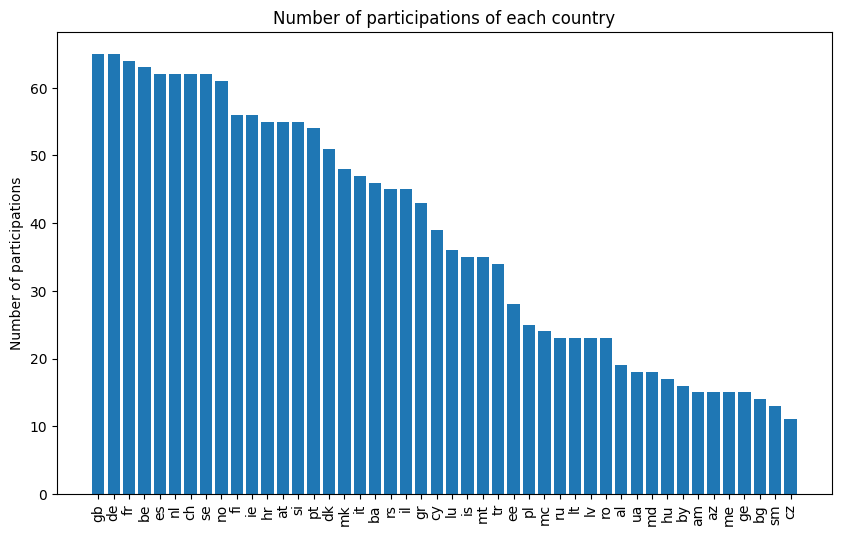

In [117]:
# Delete the countries with less than 10 participations
participation_counts = participation_counts[participation_counts['participation_count'] >= 10]

plt.figure(figsize=(10, 6))
plt.bar(participation_counts['country_id'], participation_counts['participation_count'])
plt.xticks(rotation=90)
plt.ylabel('Number of participations')
plt.title('Number of participations of each country')
plt.show()

In [118]:
# Update teh dataframe
df_final_round = df_final_round[df_final_round['from_country_id'].isin(participation_counts['country_id'])]
df_final_round = df_final_round[df_final_round['to_country_id'].isin(participation_counts['country_id'])]

In [119]:
# Get the total number of countries
total_countries = df_final_round['from_country_id']
total_countries = np.array(total_countries)
total_countries = np.unique(total_countries)
print('Total countries:', total_countries)
print('Number of countries:', len(total_countries))

Total countries: ['al' 'am' 'at' 'az' 'ba' 'be' 'bg' 'by' 'ch' 'cy' 'cz' 'de' 'dk' 'ee'
 'es' 'fi' 'fr' 'gb' 'ge' 'gr' 'hr' 'hu' 'ie' 'il' 'is' 'it' 'lt' 'lu'
 'lv' 'mc' 'md' 'me' 'mk' 'mt' 'nl' 'no' 'pl' 'pt' 'ro' 'rs' 'ru' 'se'
 'si' 'sm' 'tr' 'ua']
Number of countries: 46


### Country analyzer

#### Number of wins

In [120]:
# Number of wins of each country
# Get the total of wins of each country
# country_wins = np.zeros((len(total_countries)))
# for year in years:
#     country_winner = 0
#     for i,country in enumerate(total_countries):
#         votes = df_votes[(df_votes['year'] == year) & (df_votes['to_country_id'] == country) & (df_votes['round'] == 'final')]
#         country_votes = votes['total_points'].sum()
#         if country_votes > country_winner:
#             country_winner = country_votes
#             winner = i
#     country_wins[winner] += 1
    

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(participation_counts['country_id'], country_wins)
plt.xticks(rotation=90)
plt.ylabel('Number of participations')
plt.title('Number of participations of each country')
plt.show()

#### One country analyzer

Number of points given by Spain before 1997 and after 1997 + Boxplot of normalized points